## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
import xgboost as xg
import lightgbm as lgb

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

from variables import feriados_2015, feriados_2018, vesperas_2015, vesperas_2018, feriados_2020, vesperas_2020

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [2]:
year = 2015

if (year == 2015):
    feriados = feriados_2015
    vesperas = vesperas_2015
    data = pd.read_csv('../data_input_zerofill_2015.csv', delimiter=";")
elif (year == 2018):
    feriados = feriados_2018
    vesperas = vesperas_2018
    data = pd.read_csv('../data_input_zerofill_2018.csv', delimiter=",")
elif (year == 2020):
    feriados = feriados_2020
    vesperas = vesperas_2020
    data = pd.read_csv('../data_input_zerofill_2020.csv', delimiter=";")


In [3]:

data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
data_model = data.loc[data.data_hora.dt.year == year].copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    # 'hora',
    'hour_sin',
    'hour_cos',
    'd_mes',
    'd_ano',
    'mes',
    'semana_do_mes',
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado',
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

# 45 *
# 3 *
# 42 *
# 51 * 
# 52 * 
# 24 * 
# 76 * 
# 26 *
# 44

busline_filter = 44

In [4]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]


In [5]:
data_model.loc[data_model.linha == busline_filter]

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
257085,44,2015-01-01 00:00:00,0,3,0.000000e+00,1.000000,0,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257086,44,2015-01-01 01:00:00,0,3,2.697968e-01,0.962917,1,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257087,44,2015-01-01 02:00:00,0,3,5.195840e-01,0.854419,2,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257088,44,2015-01-01 03:00:00,0,3,7.308360e-01,0.682553,3,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257089,44,2015-01-01 04:00:00,0,3,8.878852e-01,0.460065,4,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265961,44,2015-12-31 19:00:00,417,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
265962,44,2015-12-31 20:00:00,261,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
265963,44,2015-12-31 21:00:00,240,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
265964,44,2015-12-31 22:00:00,168,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [6]:

top100_linhas = data_model.groupby(data_model.linha).sum().sort_values('validations_per_hour', ascending=False).reset_index().index[:50].to_list()
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)]

top100_linhas_data_model.to_csv("../dados-para-modelos/2015/top100_linhas_data_model_2015.csv", index=False)
line_data_model = data_model.loc[data_model['linha'] == busline_filter].copy()
line_data_model
#sns.set(rc={'figure.figsize':(15,10)})
# sns.heatmap(top100_linhas_data_model.corr()[['validations_per_hour']].sort_values(by='validations_per_hour', ascending=False)
# , vmin=-1, vmax=1, annot=True)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
257085,44,2015-01-01 00:00:00,0,3,0.000000e+00,1.000000,0,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257086,44,2015-01-01 01:00:00,0,3,2.697968e-01,0.962917,1,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257087,44,2015-01-01 02:00:00,0,3,5.195840e-01,0.854419,2,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257088,44,2015-01-01 03:00:00,0,3,7.308360e-01,0.682553,3,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
257089,44,2015-01-01 04:00:00,0,3,8.878852e-01,0.460065,4,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265961,44,2015-12-31 19:00:00,417,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
265962,44,2015-12-31 20:00:00,261,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
265963,44,2015-12-31 21:00:00,240,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
265964,44,2015-12-31 22:00:00,168,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [7]:
#display(X)

In [8]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [9]:
# Per Line Data
X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [10]:
model_list = []

In [11]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict) * 100
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [12]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [13]:
# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

#### Random Forest Model Parameters

In [14]:
# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

# Grid Searched

In [15]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearched_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)

GridSearchedRandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DefaultRandomForestModelPipeline = make_pipeline(default_randomforest_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\victo\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 673,
 'n_jobs': 6}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': False, 'n_jobs': 2, 'normalize': True}


In [16]:
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)
performance_gridsearched_linearregression_model = get_performance(gridsearched_random_linearregression)
performance_default_linearregression_model = get_performance(default_linearregression_model)

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE', 'MAPE'], 
    index=['Regressao Linear Default', 'RandomForest Default', 'Regressao Linear Grid Searched', 'RandomForest GridSearched'])
performance_total


----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.5751962682717108, 226.54487499931764, 171.7216074289124, 1.2643521456206586e+19]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.9340437555002955, 89.26640396145604, 49.29618984645067, 2.43189315334813e+18]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.5751962682717127, 226.54487499931716, 171.72160742890867, 1.264352145620556e+19]

----------------------------------------------------

Random Forest [GRID SEARCH]: 
 [0.9526402054125082, 75.64234521678165, 48.361596487839364, 2.2424729871113344e+18]

----------------------------------------------------



,R2,RMSE,MAE,MAPE
Regressao Linear Default,0.575196,226.544875,171.721607,1.264352e+19
RandomForest Default,0.934044,89.266404,49.296190,2.431893e+18
Regressao Linear Grid Searched,0.575196,226.544875,171.721607,1.264352e+19
RandomForest GridSearched,0.952640,75.642345,48.361596,2.242473e+18


In [17]:
RidgeRegressionModel = Ridge(alpha=.5)
ridge = RidgeRegressionModel.fit(X_train, Y_train)
performance_ridge = get_performance(ridge)
df2 = pd.DataFrame([performance_ridge], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Ridge Regression'])
performance_total = pd.concat([df2, performance_total])


In [18]:
DecitionTreeModel = DecisionTreeRegressor()
dtm = DecitionTreeModel.fit(X_train, Y_train)
performance_dtm = get_performance(dtm)
df2 = pd.DataFrame([performance_dtm], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Arvore de Decisao'])
performance_total = pd.concat([df2, performance_total])


In [19]:
SVRModel = SVR()
svr = SVRModel.fit(X_train, Y_train)
performance_SVR = get_performance(svr)
df2 = pd.DataFrame([performance_SVR], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['SVR Regression'])
performance_total = pd.concat([df2, performance_total])

# BAGGING

In [20]:
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(gridsearched_random_linearregression)
RandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DecisionTreeModelPipeline = make_pipeline(dtm)

bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)
bagging_dt_model, performance_bagging_dt_model = bagging_model(DecisionTreeModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model, performance_bagging_dt_model], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Regressao Linear Bagging', 'RandomForest Bagging', 'Decision Tree Bagging'])
performance_total = pd.concat([df2, performance_total])

BaggingLinearRegressionModelPipeline = make_pipeline(bagging_lr_model)
BaggingRandomForestModelPipeline = make_pipeline(bagging_rf_model)
BaggingDecisionTreeModelPipeline = make_pipeline(bagging_dt_model)



Performance for base estimator Pipeline(steps=[('linearregression',
                 LinearRegression(fit_intercept=False, n_jobs=2,
                                  normalize=True))]) = [0.5753789195324729, 226.49616643961684, 171.64838768132321, 1.2669403771123485e+19]

Performance for base estimator Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_depth=60,
                                       max_features='sqrt', min_samples_split=5,
                                       n_estimators=673, n_jobs=6))]) = [0.9504637736214129, 77.36090468874018, 50.06435672008227, 2.628410465741402e+18]

Performance for base estimator Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor())]) = [0.9258519984237844, 94.64764348505922, 52.05188211806952, 2.5134487300216883e+18]



# BOOSTING

In [22]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['GradientBoostingRegressor'])

GradientBoostingModelPipeline = make_pipeline(gradient_boosting_regressor)

performance_total = pd.concat([df2, performance_total])


# STACKING

In [23]:
estimators = [
    ('gridseached_randomforest', GridSearchedRandomForestModelPipeline),
    ('bagging_randomforest',BaggingRandomForestModelPipeline),
    ('gradient_boosting', GradientBoostingModelPipeline),
    ('random_forest_default', DefaultRandomForestModelPipeline)
]

stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegressionModelPipeline, cv= 5, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])

# extreme Gradient Boosting

In [63]:
xgb_r = xg.XGBRegressor(n_estimators = 100, seed = 42, eval_metric='mae', booster='gbtree')
xgb_r.fit(X_train, Y_train)
performance = get_performance(xgb_r)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['extremeGradientBoosting'])

performance_total = pd.concat([df2, performance_total])

In [64]:
performance_total

,R2,RMSE,MAE,MAPE
extremeGradientBoosting,0.970148,62.139214,43.357706,8.820434e+15
Stacking Regressors,0.970148,62.139214,43.357706,8.820434e+15
GradientBoostingRegressor,0.967365,62.791296,42.200692,2.116460e+18
Stacking Regressors,0.967437,62.722198,42.630869,1.925401e+18
RandomForest GridSearched,0.952640,75.642345,48.361596,2.242473e+18
RandomForest Default,0.934044,89.266404,49.296190,2.431893e+18
RandomForest Bagging,0.950464,77.360905,50.064357,2.628410e+18
Decision Tree Bagging,0.925852,94.647643,52.051882,2.513449e+18
Arvore de Decisao,0.850421,134.429862,64.877884,2.201872e+18
Regressao Linear Bagging,0.575379,226.496166,171.648388,1.266940e+19


### Todos os modelos treinados dentro de *model_list*

In [28]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    gridsearch_result_randomforest
]

In [31]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict)
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [32]:

# brf = BaggingRegressor(base_estimator=RandomForestModel,
#                             n_estimators=10,
#                             max_samples=1.0,
#                             bootstrap=True, # Samples are drawn with replacement
#                             n_jobs= n_jobs,
#                             random_state=random_state).fit(X_train, Y_train)

In [189]:
# 45 *
# 3 *
# 42 *
# 51 * 
# 52 * 
# 24 * 
# 76 * 
# 26 *
# 44
busline_filter = 45
line_data_model = data_model.loc[data_model['linha'] == busline_filter].copy()
line_data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
265966,45,2015-01-01 01:00:00,0,3,2.697968e-01,0.962917,1,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
265967,45,2015-01-01 02:00:00,0,3,5.195840e-01,0.854419,2,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
265968,45,2015-01-01 03:00:00,0,3,7.308360e-01,0.682553,3,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
265969,45,2015-01-02 01:00:00,0,4,2.697968e-01,0.962917,1,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
265970,45,2015-01-02 02:00:00,0,4,5.195840e-01,0.854419,2,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,45,2015-12-31 19:00:00,582,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
274856,45,2015-12-31 20:00:00,508,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
274857,45,2015-12-31 21:00:00,335,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
274858,45,2015-12-31 22:00:00,204,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


# Prever 24hrs (geracao de grafico)

In [190]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     gridsearch_result_randomforest
# RandomForest GridSearched
# RandomForest Bagging


    # objective ='reg:linear',
                  
  
# Fitting the model
xgb_r = xg.XGBRegressor(n_estimators = 100, eval_metric='mae', booster='gbtree')
df_perf = pd.DataFrame()
for i in range(0, 11):
    meses_de_treino = [1,2,3,4,5,6,7,8,9,10]
    mes_de_previsao = 11

    line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)].copy()

    X = line_mes_data_model.filter(feature_names, axis=1)
    y = line_mes_data_model.validations_per_hour
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

    estimators = [
        ('decision_tree', dtm),
        ('linear_regression', LinearRegressionModel),
        ('e_gradient_boosting', xgb_r),
        # ('rf', RandomForestModel)
    ]

    stack = StackingRegressor(estimators=estimators, final_estimator=RandomForestModel, cv= 7, passthrough = True)
    
    model = stack

    line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao].copy()
    # .loc[line_mes_data_model_predict.d_mes < 6]
    df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes >= 1].loc[line_mes_data_model_predict.d_mes < 8].filter(feature_names, axis = 1).copy()
    real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes >= 1].loc[line_mes_data_model_predict.d_mes < 8].validations_per_hour).copy()

    predictions = []
    performances = list()

    model.fit(X_train, Y_train)
    performances.append(get_performance(model))

    for index, row in df_prev.iterrows():
        row_df = pd.DataFrame(row).T
        predictions.append(model.predict(row_df.values)[0])
    
    df_perf = pd.concat([df_perf, pd.DataFrame(performances)])
    df_predict_dados = real_values
    df_predict_dados['validations_per_hour_predicted'] = predictions

In [191]:
import decimal
        
def value_to_decimal(value, decimal_places):
    decimal.getcontext().rounding = decimal.ROUND_HALF_UP  # define rounding method
    return decimal.Decimal(str(float(value))).quantize(decimal.Decimal('1e-{}'.format(decimal_places)))

print(value_to_decimal(df_perf[0].mean(), 6))
print(value_to_decimal(df_perf[1].mean(), 6))
print(value_to_decimal(df_perf[2].mean(), 6))
print(value_to_decimal(df_perf[3].mean()/10**15, 6))

0.975462
66.573389
41.756060
6.497725


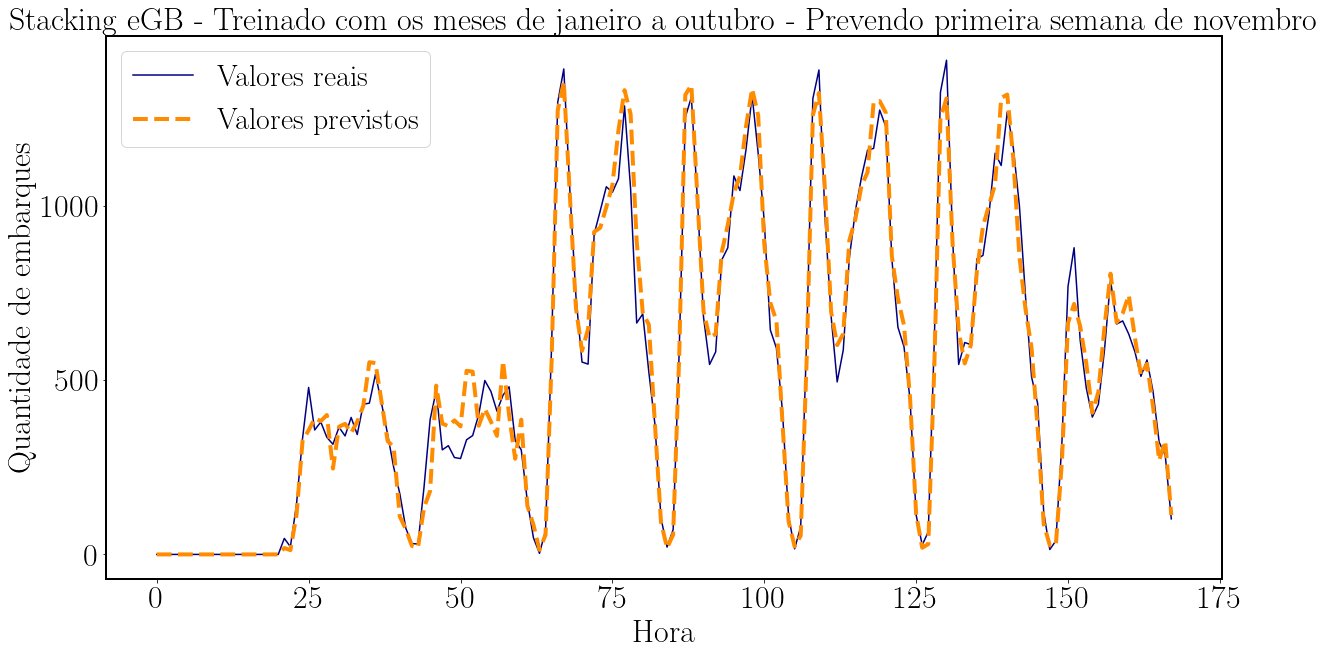

In [192]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168
# plt.rc('patch',linewidth=2)
plt.rc('axes', linewidth=2, labelpad=5)
# plt.rc('xtick.minor', size=8, width=4)
# plt.rc('ytick.minor', size=8, width=4)
# ax.set_facecolor("white")
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern', size=42)
plt.figure(figsize=(20,10))
plt.plot(range(df_predict_dados.validations_per_hour.size), df_predict_dados.validations_per_hour.values, color='navy', label="Valores reais")
plt.plot(range(predictions.__len__()), predictions, color='darkorange',linestyle='dashed', label="Valores previstos", linewidth=4)
# plt.plot(range(df_Abril_xGB.__len__()), df_Abril_xGB, color='indigo',linestyle='dashed', label="Valores previstos: Random Forest", linewidth=2)
# plt.plot(range(df_Abril_StackingA.__len__()), df_Abril_StackingA, color='rebeccapurple',linestyle='dashed', label="Valores previstos: Stacking A", linewidth=2)


# plt.xticks(range(0,24))
modelo = 'Stacking eGB'
plt.legend(fontsize=30)
plt.xlabel('Hora', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.title(f"{modelo} - Treinado com os meses de janeiro a outubro - Prevendo primeira semana de novembro", fontsize=32)
plt.ylabel('Quantidade de embarques', fontsize=32)
plt.savefig(f'../images/apendice-{busline_filter}-{modelo}-{year}-predict-1wNov.pdf')
plt.show()

In [193]:

# real_values = df_predict_dados.validations_per_hour
# predictions = predictions

# plt.rc('patch',linewidth=2)
# plt.rc('axes', linewidth=2, labelpad=5)
# plt.rc('xtick.minor', size=8, width=4)
# plt.rc('ytick.minor', size=8, width=4)

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', serif='Computer Modern', size=18)
# plt.figure(figsize=(10,10))
# plt.scatter(real_values, predictions, c='darkcyan')

# p1 = max(max(predictions), max(real_values.values))
# p2 = min(min(predictions), min(real_values.values))
# plt.plot([p1, p2], [p1, p2], 'brown')

# plt.xlabel('Valores Reais', fontsize=18)
# plt.ylabel('Valores previstos', fontsize=18)
# plt.axis('equal')

# plt.savefig(f'../images/apendice-{busline_filter}-{modelo}-{year}-predict-10nov-scatterplot.pdf')
# plt.show()

# Treinar com 1 mes, prever N semanas

In [194]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

# meses_de_treino = [1,2,3]
# mes_de_previsao = 4

# line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)]

# line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

# df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  8].filter(feature_names, axis = 1)
# real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  8].validations_per_hour)

# X = line_mes_data_model.filter(feature_names, axis=1)
# y = line_mes_data_model.validations_per_hour
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

# predictions = [[],[],[],[],[]]
# performances = list()

# for i, model in enumerate(model_list):
#         model.fit(X_train, Y_train)
#         performances.append(get_performance(model))

#         for index, row in df_prev.iterrows():
#             predictions[i].append(model.predict([row])[0])


In [195]:
# df_performance = pd.DataFrame(performances)
# df_performance.to_csv('../performances/2015/linha'+str(busline_filter)+'_'+str(meses_de_treino)+'meses_1semana('+str(mes_de_previsao)+')_performance.csv', index=False)
# df_predict_dados = real_values
# df_predict_dados['validations_per_hour_predicted'] = predictions[0]

# df_predict_dados.to_csv('../predict-vs-real/2015/linha'+str(busline_filter)+'_'+str(meses_de_treino)+'meses_1semana('+str(mes_de_previsao)+')_predict.csv', index=False)

# df_performance

In [196]:
# # 168 == quantidade de horas previstas em 1 semana
# plt_size = 168

# plt.figure(figsize=(30, 10))
# plt.plot(range(df_predict_dados.validations_per_hour.size), df_predict_dados.validations_per_hour.values, color='blue')
# plt.plot(range(predictions[0].__len__()), predictions[0], color='red')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.show()

In [197]:
# line_data_model.loc[line_data_model.mes == 4].loc[line_data_model.d_mes < 8]

### Treinar com (N-Y) meses, Prever mes (N)

In [198]:
# # Jan, Fev, Mar, Abril, Maio
# # treina com mar, preve 2 semanas de abril

# meses_de_treino = [1,2,3]
# mes_de_previsao = 4
# dias_de_previsao = 7

# line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)]

# line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

# df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  dias_de_previsao+1].filter(feature_names, axis = 1)
# real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  dias_de_previsao+1].validations_per_hour)

# X = line_mes_data_model.filter(feature_names, axis=1)
# y = line_mes_data_model.validations_per_hour
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

# predictions = [[],[],[],[],[]]
# performances = list()

# for i, model in enumerate(model_list):
#         model.fit(X_train, Y_train)
#         performances.append(get_performance(model))

#         for index, row in df_prev.iterrows():
#             predictions[i].append(model.predict([row])[0])


In [199]:
# 168 == quantidade de horas previstas em 1 semana
# plt_size = 168

# plt.figure(figsize=(30, 10))
# plt.plot(range(df_results.size), df_results.values, color='blue')
# plt.plot(range(predictions.__len__()), predictions, color='red')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.show()

In [200]:
# performances

## Ranking Linhas de Onibus

In [201]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
# res_map = list()
# top100_linhas = data_model.linha.value_counts().index[:100]

# for linha in top100_linhas:
#     currentLinhaData = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == linha].copy()
#     X = currentLinhaData.filter(feature_names, axis=1)
#     y = currentLinhaData.validations_per_hour
#     X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
#     for model in model_list:
#         model.fit(X_train, Y_train)
#         performance = get_performance(model)
#         performance.insert(0, linha)
#         res_map.append(performance)
# res_map = pd.DataFrame(res_map, columns=["Linha", "R2", "RMSE", "MAE", 'MAPE'])
# r = res_map.sort_values('MAE', ascending=True)
# r.to_csv("../performances/2015/ranking_top100_2015.csv", index=False)



In [202]:
# res_map = pd.DataFrame(res_map,columns=['Linha', 
#     # '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     # '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     # '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' 
#     ])
# res_map = pd.DataFrame(res_map,columns=['Linha','R2', 'RMSE', 'MAE', 'MAPE'])

# #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
# res_map = res_map.sort_values('MAE', ascending=True).reset_index(drop=True)
# res_map = res_map.drop_duplicates(subset='Linha', keep="first").reset_index(drop=True)
# res_map.to_csv('../top100linhas_rank_2015.csv', index=False)
# res_map